In [1]:
import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import mannwhitneyu
import math
import numpy as np
from scipy.spatial.distance import jaccard
# from scipy.spatial.distance import pdist
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from tqdm.auto import tqdm

/home/dylan/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This project received funding from the European Union’s Horizon 2020 research and innovation programme [952914] (FindingPheno).

## Loading the available data:

First a table that maps SNPS ("marker") to genes ("GeneSymbol")

In [2]:
themap = pd.read_csv("../../data/salmon_data/HoloFish_HostG_SNP_annotation_GENES.txt")

In [3]:
themap.head()

,marker,GeneSymbol,Class
0,NC_059442.1_219649,LOC123726714,protein_coding
1,NC_059442.1_422675,wdr32,protein_coding
2,NC_059442.1_423636,wdr32,protein_coding
3,NC_059442.1_424097,wdr32,protein_coding
4,NC_059442.1_424181,wdr32,protein_coding


Next, we have a table that carries the metadata of the samples:

In [4]:
metadata = pd.read_csv("../../data/salmon_data/HoloFish_FishVariables_20221116.csv")
metadata.head()

,Sample.ID,Size.class,Gutted.Weight.kg,Tapeworm.index,Tapeworm.present,Feed.Type,Metabolome.batch,HostG.Ind.ID,Dataset.MetaG,Dataset.HostRNA,Dataset.Metabolome,Dataset.HostG
0,F001,Medium,3.24,1,True,Feed1,Batch_1,Ind0,False,True,True,True
1,F010,Small,1.77,1,True,Feed1,Batch_1,Ind8,True,True,True,True
2,F100,Medium,3.15,1,True,Feed1,NaN,NaN,False,False,False,False
3,F101,Medium,3.21,1,True,Feed1,Batch_3,Ind87,True,True,True,True
4,F102,Medium,3.34,1,True,Feed1,Batch_3,Ind88,True,True,True,True


A table that maps genes to their associated GO terms. Notice that many genes (symbol) are not associated to any GO term

In [5]:
go = pd.read_csv("../../data/salmon_data/salmon_GO_annotations.tsv", sep="\t")

In [6]:
go.head()

,SYMBOL,ENTREZID,GENENAME,GO,ONTOLOGY,GO.term
0,1433b,100196586.0,14-3-3 protein beta/alpha,NaN,NaN,NaN
1,143b2,100195171.0,14-3-3 protein beta/alpha-2,GO:0004497,MF,"Term = \monooxygenase activity\"""""
2,143g1,100380373.0,14-3-3 protein gamma-1,NaN,NaN,NaN
3,143g2,100194987.0,14-3-3 protein gamma-2,NaN,NaN,NaN
4,2a5e,100195340.0,Serine/threonine-protein phosphatase 2A 56 kDa...,GO:0000159,CC,"Term = \protein phosphatase type 2A complex\"""""


So we'll drop the genes with no association:

In [7]:
go = go.dropna()
go.head()

,SYMBOL,ENTREZID,GENENAME,GO,ONTOLOGY,GO.term
1,143b2,100195171.0,14-3-3 protein beta/alpha-2,GO:0004497,MF,"Term = \monooxygenase activity\"""""
4,2a5e,100195340.0,Serine/threonine-protein phosphatase 2A 56 kDa...,GO:0000159,CC,"Term = \protein phosphatase type 2A complex\"""""
5,2a5e,100195340.0,Serine/threonine-protein phosphatase 2A 56 kDa...,GO:0019888,MF,Term = \protein phosphatase regulator activit...
6,2a5e,100195340.0,Serine/threonine-protein phosphatase 2A 56 kDa...,GO:0007165,BP,"Term = \signal transduction\"""""
7,4f2,100195278.0,4F2 cell-surface antigen heavy chain,GO:0016020,CC,"Term = \membrane\"""""


We want to keep only the SNPs that map to genes for which we have GO terms.
First we'll isolate the "GO-genes":

In [8]:
go_genes = list(go.SYMBOL.unique())

And then, from the "themap" table, we keep only the rows where the gene name is found inside the "go_genes" list:

In [9]:
# relevant_mutations = themap[themap.GeneSymbol.isin(go_genes)].copy()
# relevant_mutations.head()
relevant_mutations = themap # don't drop non-associated genes

In [10]:
relevant_mutations.shape

(2009286, 3)

There's 1117765 SNPs/markers left in our table at this point

## How many mutations are mapped to each gene?

The 'relevant mutations' table maps markers to genes, so it allows us to easily count markers per gene and plot it as a histogram:

/home/dylan/miniconda3/envs/gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

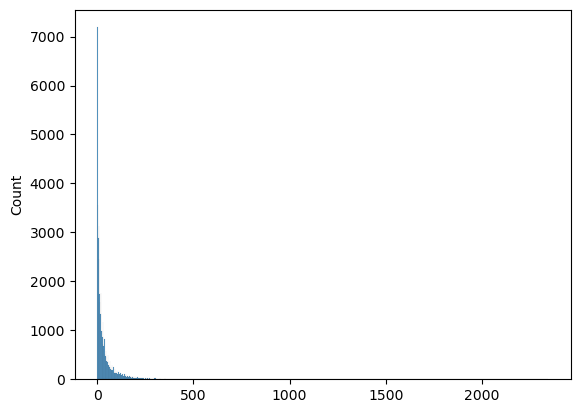

In [11]:
sns.histplot( relevant_mutations.GeneSymbol.value_counts().values )

/home/dylan/miniconda3/envs/gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

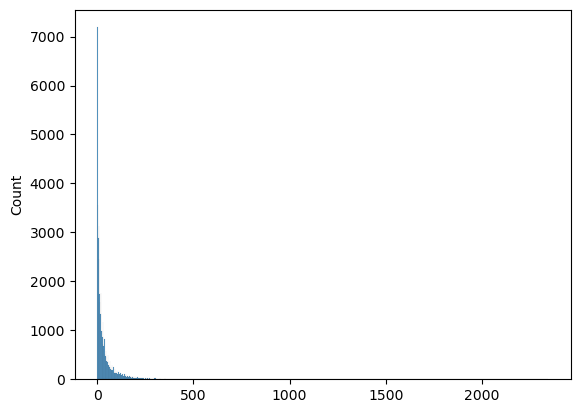

In [12]:
sns.histplot( relevant_mutations.GeneSymbol.value_counts().values )

# plt.xlim((500,3000))

We can see that the vast majority of genes are assigned a small number of SNPs, while very few of them have up to 2000 markers assigned to them.

In [13]:
# 97.5% of genes have less SNPs than:
np.quantile( relevant_mutations.GeneSymbol.value_counts().values, .975)

264.0

## More data loading:

The gwasdf is the big table that keeps the dosage data per sample per SNP:

In [14]:
gwasdf = pd.read_csv("../../data/salmon_data/HoloFish_HostG_GenotypeProbability.dose", sep=" ")

In [15]:
gwasdf.head()

,marker,alleleA,alleleB,Ind0,Ind1,Ind2,Ind3,Ind4,Ind5,Ind6,...,Ind351,Ind352,Ind353,Ind354,Ind355,Ind356,Ind357,Ind358,Ind359,Ind360
0,NC_059442.1_84727,0,2,1.0000,0.0013,0.9780,0.0035,0.0002,0.0005,0.000,...,0.9999,0.1223,0.0013,0.9994,0.0013,0.9996,0.0347,0.0053,0.0035,0.8773
1,NC_059442.1_84730,1,3,1.0000,0.0005,0.9713,0.0020,0.0001,0.0001,0.000,...,0.9995,0.1111,0.0005,0.9985,0.0005,0.9989,0.0289,0.0040,0.0020,0.8659
2,NC_059442.1_132329,0,1,0.0334,0.0647,0.1294,0.1294,0.0086,0.0086,0.017,...,0.0043,0.0334,0.0334,0.9559,0.9886,0.1294,0.0334,0.1294,0.0000,0.0022
3,NC_059442.1_141907,2,3,0.2496,1.0000,1.0000,1.0002,1.0000,0.0419,1.000,...,1.9880,0.0058,1.0000,0.0005,1.0000,1.8395,1.0000,1.0013,0.0001,1.0000
4,NC_059442.1_141912,2,0,0.2462,1.0000,1.0000,1.0009,1.0000,0.0395,1.000,...,1.9871,0.0052,1.0000,0.0004,1.0000,1.8367,1.0000,1.0063,0.0001,1.0000


In [16]:
gwasdf.shape

(3440818, 364)

The gwasdf names the samples as "Ind0","Ind1" etc, but we've been using the "F001" samples IDs from the other tables, 
so we'll need to rename the samples:

In [17]:
# Load a mapping of IndX --> FXXX names
sidm = pd.read_csv("../../data/salmon_data/HoloFish_FishVariables_20221116.csv")
sidm = sidm[["Sample.ID","HostG.Ind.ID"]]
sampleD = {b:a for a,b in sidm.dropna().values}
# rename the samples in the raw gwasdf
gwasdf.columns = list(gwasdf.columns[:3]) + [sampleD.get(x) for x in gwasdf.columns[3:]]

In [18]:
gwasdf.head()

,marker,alleleA,alleleB,F001,F002,F003,F004,F005,F006,F007,...,F444,F445,F446,F447,F448,F449,F450,F451,F460,F461
0,NC_059442.1_84727,0,2,1.0000,0.0013,0.9780,0.0035,0.0002,0.0005,0.000,...,0.9999,0.1223,0.0013,0.9994,0.0013,0.9996,0.0347,0.0053,0.0035,0.8773
1,NC_059442.1_84730,1,3,1.0000,0.0005,0.9713,0.0020,0.0001,0.0001,0.000,...,0.9995,0.1111,0.0005,0.9985,0.0005,0.9989,0.0289,0.0040,0.0020,0.8659
2,NC_059442.1_132329,0,1,0.0334,0.0647,0.1294,0.1294,0.0086,0.0086,0.017,...,0.0043,0.0334,0.0334,0.9559,0.9886,0.1294,0.0334,0.1294,0.0000,0.0022
3,NC_059442.1_141907,2,3,0.2496,1.0000,1.0000,1.0002,1.0000,0.0419,1.000,...,1.9880,0.0058,1.0000,0.0005,1.0000,1.8395,1.0000,1.0013,0.0001,1.0000
4,NC_059442.1_141912,2,0,0.2462,1.0000,1.0000,1.0009,1.0000,0.0395,1.000,...,1.9871,0.0052,1.0000,0.0004,1.0000,1.8367,1.0000,1.0063,0.0001,1.0000


In [19]:
gwasdf.shape

(3440818, 364)

To further process this table, we'll drop the "alleleA/alleleB" columns and set the "marker" column as index.     
Then we'll only keep the SNPs that we've kept in the "relevant_mutations" table:

In [20]:
gwasi = gwasdf.set_index("marker").drop(["alleleA","alleleB"], axis=1)
#gwasi = gwasi.loc[list(set(relevant_mutations.marker.values))]

In [21]:
gwasi.shape

(3440818, 361)

In [22]:
gwasi.head()

,F001,F002,F003,F004,F005,F006,F007,F008,F010,F011,...,F444,F445,F446,F447,F448,F449,F450,F451,F460,F461
marker,,,,,,,,,,,,,,,,,,,,,
NC_059442.1_84727,1.0000,0.0013,0.9780,0.0035,0.0002,0.0005,0.000,0.0000,0.0005,0.0106,...,0.9999,0.1223,0.0013,0.9994,0.0013,0.9996,0.0347,0.0053,0.0035,0.8773
NC_059442.1_84730,1.0000,0.0005,0.9713,0.0020,0.0001,0.0001,0.000,0.0000,0.0002,0.0076,...,0.9995,0.1111,0.0005,0.9985,0.0005,0.9989,0.0289,0.0040,0.0020,0.8659
NC_059442.1_132329,0.0334,0.0647,0.1294,0.1294,0.0086,0.0086,0.017,0.1294,0.0001,0.1294,...,0.0043,0.0334,0.0334,0.9559,0.9886,0.1294,0.0334,0.1294,0.0000,0.0022
NC_059442.1_141907,0.2496,1.0000,1.0000,1.0002,1.0000,0.0419,1.000,1.0003,0.0001,1.0000,...,1.9880,0.0058,1.0000,0.0005,1.0000,1.8395,1.0000,1.0013,0.0001,1.0000
NC_059442.1_141912,0.2462,1.0000,1.0000,1.0009,1.0000,0.0395,1.000,1.0001,0.0000,1.0000,...,1.9871,0.0052,1.0000,0.0004,1.0000,1.8367,1.0000,1.0063,0.0001,1.0000


In [23]:
all_as_ints = np.round(gwasi.values).flatten()
from collections import Counter
def calculate_proportions(int_list):
    # Count occurrences of each integer
    count = Counter(int_list)
    
    # Total number of integers in the list
    total = len(int_list)
    
    # Calculate and print proportions
    proportions = {key: value / total for key, value in count.items()}
    return proportions
proportions = calculate_proportions(all_as_ints)

for integer, proportion in proportions.items():
    print(f"Integer: {integer}, Proportion: {proportion:.4f}")

Integer: 1.0, Proportion: 0.3017
Integer: 0.0, Proportion: 0.6623
Integer: 2.0, Proportion: 0.0360


## Code to evaluate results on a random dataset

In [24]:
import random
source_list = [0, 1, 2]
weights = [0.6487, 0.3115, 0.0397]  
n = gwasi.shape[0] * gwasi.shape[1]
random_df = random.choices(source_list, weights=weights, k=n)

In [25]:
random_df_vals = np.array(random_df).reshape((gwasi.shape[0], gwasi.shape[1]))

In [26]:
## Uncomment to proceed with a random dataset
# random_df = pd.DataFrame(data=random_df_vals, columns = gwasi.columns, index=gwasi.index)
# gwasi = random_df 

In [27]:
gwasi.head()

,F001,F002,F003,F004,F005,F006,F007,F008,F010,F011,...,F444,F445,F446,F447,F448,F449,F450,F451,F460,F461
marker,,,,,,,,,,,,,,,,,,,,,
NC_059442.1_84727,1.0000,0.0013,0.9780,0.0035,0.0002,0.0005,0.000,0.0000,0.0005,0.0106,...,0.9999,0.1223,0.0013,0.9994,0.0013,0.9996,0.0347,0.0053,0.0035,0.8773
NC_059442.1_84730,1.0000,0.0005,0.9713,0.0020,0.0001,0.0001,0.000,0.0000,0.0002,0.0076,...,0.9995,0.1111,0.0005,0.9985,0.0005,0.9989,0.0289,0.0040,0.0020,0.8659
NC_059442.1_132329,0.0334,0.0647,0.1294,0.1294,0.0086,0.0086,0.017,0.1294,0.0001,0.1294,...,0.0043,0.0334,0.0334,0.9559,0.9886,0.1294,0.0334,0.1294,0.0000,0.0022
NC_059442.1_141907,0.2496,1.0000,1.0000,1.0002,1.0000,0.0419,1.000,1.0003,0.0001,1.0000,...,1.9880,0.0058,1.0000,0.0005,1.0000,1.8395,1.0000,1.0013,0.0001,1.0000
NC_059442.1_141912,0.2462,1.0000,1.0000,1.0009,1.0000,0.0395,1.000,1.0001,0.0000,1.0000,...,1.9871,0.0052,1.0000,0.0004,1.0000,1.8367,1.0000,1.0063,0.0001,1.0000


## The dosage values

A value of 0 means that there's probability 1 that the sample has 2 wt alleles.
A value of 1 means there's probability of 1 that the sample has one variant and one wt allele.
A value of 2 means that there's probability of 1 that the sample has 2 variabt alleles.

Thus, any value over 0.5 means that the sample has more than 0.5 probability to have at least one variant allele:

In [28]:
# So we'll make a binary version of our table:
gwasib = (gwasi>0.5).astype(bool)
# And we'll filter out the very few cases of SNPs where ALL samples have the variant allele:
mask = gwasib.sum(axis=1)<361
gwasib_f = gwasib[mask]
gwasi_f = gwasi[mask]

In [29]:
gwasib_f.shape

(3440769, 361)

In [30]:
gwasib.shape

(3440818, 361)

In [31]:
gwasib_f.head()

,F001,F002,F003,F004,F005,F006,F007,F008,F010,F011,...,F444,F445,F446,F447,F448,F449,F450,F451,F460,F461
marker,,,,,,,,,,,,,,,,,,,,,
NC_059442.1_84727,True,False,True,False,False,False,False,False,False,False,...,True,False,False,True,False,True,False,False,False,True
NC_059442.1_84730,True,False,True,False,False,False,False,False,False,False,...,True,False,False,True,False,True,False,False,False,True
NC_059442.1_132329,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False
NC_059442.1_141907,False,True,True,True,True,False,True,True,False,True,...,True,False,True,False,True,True,True,True,False,True
NC_059442.1_141912,False,True,True,True,True,False,True,True,False,True,...,True,False,True,False,True,True,True,True,False,True


## The weights table

The final data table we'll need is an array with the weight of every sample:

In [32]:
# gwasi.T.index.values here is all our samples in the order with which they were found in the other data tables
weights = metadata.set_index("Sample.ID").loc[gwasi.T.index.values, ["Gutted.Weight.kg"] ].values.squeeze()
weights = weights.squeeze()

In [33]:
weights

array([3.24 , 4.18 , 5.89 , 4.89 , 3.98 , 2.01 , 4.74 , 4.7  , 1.77 ,
       4.24 , 2.57 , 4.3  , 4.27 , 3.94 , 4.76 , 5.23 , 5.11 , 4.27 ,
       1.57 , 4.28 , 1.47 , 1.48 , 0.995, 2.05 , 3.92 , 1.77 , 4.71 ,
       4.37 , 1.31 , 5.11 , 3.81 , 1.1  , 3.96 , 4.39 , 4.75 , 2.145,
       1.47 , 1.62 , 4.43 , 0.92 , 1.7  , 2.3  , 4.44 , 1.67 , 1.44 ,
       4.   , 1.6  , 1.7  , 1.18 , 2.01 , 2.14 , 4.6  , 1.165, 4.85 ,
       2.115, 4.45 , 3.57 , 1.72 , 3.7  , 0.78 , 1.4  , 1.48 , 1.54 ,
       1.8  , 0.935, 2.9  , 3.57 , 3.69 , 1.41 , 1.86 , 2.57 , 4.04 ,
       4.75 , 2.33 , 2.76 , 3.49 , 3.97 , 1.51 , 4.91 , 3.47 , 3.115,
       3.63 , 2.77 , 2.4  , 4.31 , 2.485, 3.065, 3.21 , 3.34 , 5.22 ,
       3.57 , 3.4  , 3.99 , 1.24 , 3.73 , 2.51 , 2.57 , 3.34 , 4.3  ,
       4.21 , 3.72 , 2.17 , 3.05 , 2.445, 2.25 , 3.56 , 1.17 , 5.55 ,
       4.11 , 4.49 , 2.94 , 4.85 , 2.3  , 3.64 , 3.35 , 5.2  , 4.15 ,
       3.18 , 4.54 , 3.345, 4.04 , 3.215, 3.8  , 2.2  , 0.94 , 5.24 ,
       2.72 , 5.1  ,

## We now have all the data we need.

Let's perform our analysis for a single SNP to understand what it is.     
We ask the question "Are the fish that have at least one variant allele significantly larger or smaller than those that don't" ?

To perform this test, we need to select one SNP, let's take the very first one:

In [34]:
test_snp_index = 0

In [35]:
gwasib_f.iloc[0]

F001     True
F002    False
F003     True
F004    False
F005    False
        ...  
F449     True
F450    False
F451    False
F460    False
F461     True
Name: NC_059442.1_84727, Length: 361, dtype: bool

So this is marker NC_059454.1_82927125, and we have a true/false value per sample.

And we also have the weights of all the samples:

In [36]:
weights[:3]

array([3.24, 4.18, 5.89])

We can use the True/False values of the marker to mask the weights array like this:

In [37]:
row = gwasib_f.iloc[1]
weights_of_samples_that_have = weights[row]
weights_of_samples_that_dont = weights[~row]

And now we can perform the statistical test on this:

In [38]:
score_greater, p_greater = mannwhitneyu( weights_of_samples_that_have,weights_of_samples_that_dont, alternative="greater" )
score_less, p_less = mannwhitneyu( weights_of_samples_that_have,weights_of_samples_that_dont, alternative="less" )

In [39]:
p_greater,p_less

(0.04040216107517343, 0.959767036935781)

In this case, we got a p value of 0.2 that the samples that have the variable allele are significantly larger than those that don't.

Performing this test for all SNPs will be very slow, but it is a very easy to parallelize task:

We will spawn multiple processes (instead of just one which is they typical approach), where each process will perform the statistical test in a subset of SNPs.

In [40]:
# import the multiprocessing library for python:
from multiprocessing import Pool, TimeoutError

# define what each separate process will do
# we will be passing the snp row to each process as an argument
# since those are different.
# but each process will create its own copy of the weights
# since those are always the same
def generator_process_f(snp_row):
    marker,row = snp_row
    # make own copy of this array for each process spawned
    weights = metadata.set_index("Sample.ID").loc[gwasi.T.index.values, ["Gutted.Weight.kg"] ].values.squeeze()
    # make the two tests:
    _,pg = mannwhitneyu( weights[row],weights[~row], alternative="greater" )
    _,pl = mannwhitneyu( weights[row],weights[~row], alternative="less" )
    # return the SNP name,p values and the sum of the row which is how many samples have at least one variant allele
    return marker,pg, pl,row.sum()


class Processor(object):
    """The code to be executed by each individual process"""
    def __init__(self, weights):
        """Initialize the class. We do this so that each process only loads the weights array once:"""
        self.weights = weights

    def __call__(self, snp_row):
        marker,row = snp_row
        # make own copy of this array for each process spawned
        # weights = metadata.set_index("Sample.ID").loc[gwasi.T.index.values, ["Gutted.Weight.kg"] ].values.squeeze()
        # make the two tests:
        _,pg = mannwhitneyu( self.weights[row],self.weights[~row], alternative="greater" )
        _,pl = mannwhitneyu( self.weights[row],self.weights[~row], alternative="less" )
        _,pts = mannwhitneyu( self.weights[row],self.weights[~row], alternative="two-sided" )
        # return the SNP name,p values and the sum of the row which is how many samples have at least one variant allele
        return marker,pg, pl, pts, row.sum()


## One final optimization

We have been keeping our data in pandas tables, but numpy arrays are faster to index.
So we'll move to the numpy version of the tables:

In [41]:
ngwasib_f = gwasib_f.values.astype(bool)
markernames = gwasi_f.index.values

In [42]:
# How many cpus do we have in this machine?
import os
cpu_count = os.cpu_count()

In [43]:
# a list to keep the results:
lot = []
# the progress bar:
how_many_SNPs = gwasib_f.shape[0]
with tqdm(total=how_many_SNPs) as pbar:
    # The multiprocess pool (the pool of parallel processes)
    with Pool(processes=26) as pool:
        # Assign the jobs to the processes:
        # we iterate the rows of gwasib_f
        # and give each row to the pool of 24 processes.
        # The results come back in asynchronous order (we don't care about the order as long as we know which snp is which)
        for result in pool.imap_unordered(Processor(weights), zip(markernames,ngwasib_f)):
            lot.append(result)
            pbar.update(1) # update the progress bar

100%|██████████| 3440769/3440769 [06:18<00:00, 9102.18it/s]


In [44]:
# put the results in a dataframe
mws = pd.DataFrame(lot)
mws.columns = ["Marker", "pval_AltGreater", "pval_AltLess", "pval_two_sided", "var_count"]

In [45]:
bonferroni_threshold = -math.log10( 0.05/len(mws))
bonferroni_threshold

7.837685512402069

In [46]:
# convert the pvalues to -log10 
mws["pval_AltGreater_log"] = mws.pval_AltGreater.apply(lambda x: -math.log10(x))
mws["pval_AltLess_log"] = mws.pval_AltLess.apply(lambda x: -math.log10(x))
mws["maxscore"] = mws.apply(lambda r: max([r["pval_AltLess_log"], r["pval_AltGreater_log"]]), axis=1 )
mws["logpvalue"] = mws.pval_two_sided.apply(lambda x: -math.log10(x))
mws["significant"] = mws.maxscore>bonferroni_threshold

In [47]:
mws.sort_values("maxscore", ascending=False).head(20)

,Marker,pval_AltGreater,pval_AltLess,pval_two_sided,var_count,pval_AltGreater_log,pval_AltLess_log,maxscore,logpvalue,significant
3361161,NC_059470.1_26654650,2.202249e-14,1.0,4.404498e-14,104,13.657134,9.498626e-15,13.657134,13.356104,True
1994084,NC_059456.1_20634190,4.571459e-14,1.0,9.142919e-14,75,13.339945,1.967228e-14,13.339945,13.038915,True
3360678,NC_059470.1_26362271,4.960956e-14,1.0,9.921912e-14,106,13.304435,2.135985e-14,13.304435,13.003405,True
96642,NC_059442.1_58497104,6.238654e-14,1.0,1.247731e-13,83,13.204909,2.685652e-14,13.204909,12.903879,True
96641,NC_059442.1_58497103,6.238654e-14,1.0,1.247731e-13,83,13.204909,2.685652e-14,13.204909,12.903879,True
1994083,NC_059456.1_20634137,6.907135e-14,1.0,1.381427e-13,78,13.160702,2.970129e-14,13.160702,12.859672,True
873681,NC_059447.1_70521400,7.269689e-14,1.0,1.453938e-13,93,13.138484,3.129243e-14,13.138484,12.837454,True
968132,NC_059448.1_38081171,9.593516e-14,1.0,1.918703e-13,91,13.018022,4.132143e-14,13.018022,12.716992,True
1677249,NC_059454.1_3425874,9.798417e-14,1.0,1.959683e-13,93,13.008844,4.218933e-14,13.008844,12.707814,True
96705,NC_059442.1_58533550,1.062682e-13,1.0,2.125364e-13,84,12.973597,4.575734e-14,12.973597,12.672567,True


In [48]:
light_green = (0.0, 0.6, 0.5)
pink = (1, 0.078, 0.576)

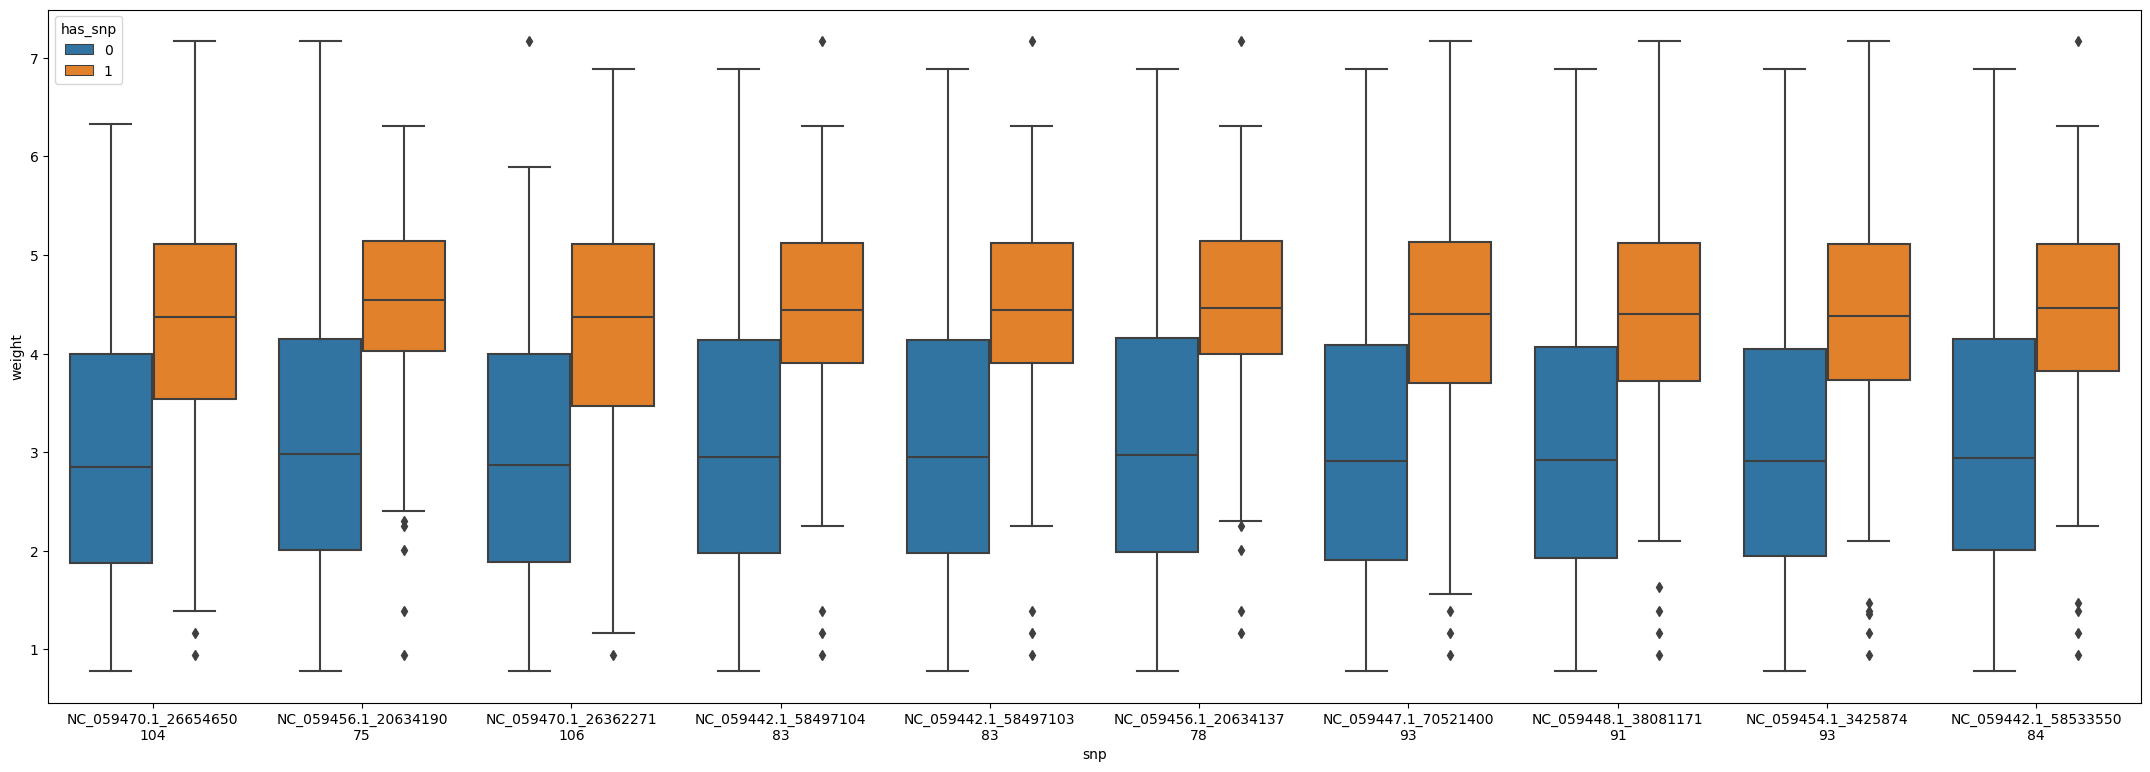

In [49]:
tenmost = mws.sort_values(by="maxscore", ascending=False).iloc[:10,:]
def meltything(row):
    foo = pd.DataFrame(gwasi.loc[row.Marker].T)
    foo[foo.columns[0]] = (foo[foo.columns[0]]>=0.5).astype(int)
    foo[["weight"]] = metadata.set_index("Sample.ID").loc[gwasi.T.index.values, ["Gutted.Weight.kg"] ]
    dt = foo.melt(id_vars="weight")
    dt.columns = ["weight","snp","has_snp"]
    return dt
lot = [meltything(r) for _,r in tenmost.iterrows()]

lot = pd.concat(lot).reset_index(drop=True)

lot["len1"] = lot.snp.map(dict(gwasib.loc[lot.snp.unique()].sum(axis=1)))

lot["snp"] = lot.snp +"\n" + lot.len1.apply(str)


plt.figure(figsize=(27,9))
#sns.boxplot(data=lot, x="snp", hue="has_snp" ,y="weight", palette=gray_scale(range(n_categories)))
sns.boxplot(data=lot, x="snp", hue="has_snp", y="weight")
plt.savefig("../../figures/GFGWA_boxplot.pdf")

In [50]:
marker_to_gene_d = dict(themap[["marker","GeneSymbol"]].values)
mws["gene"] = mws["Marker"].map(marker_to_gene_d)
gene_significance_sums = mws.groupby("gene").apply(lambda g: g.significant.sum())

In [51]:
gene_significance_sums.sort_values(ascending=False)

gene
LOC106599468    82
arhgap17a       64
LOC106568787    61
LOC106565964    61
LOC106610595    58
                ..
LOC106583612     0
LOC106583614     0
LOC106583615     0
LOC106583616     0
zzef1            0
Length: 45322, dtype: int64

In [52]:
lot2 = []
for gene,g in relevant_mutations[relevant_mutations.marker.isin(gwasib_f.index.values)][["marker","GeneSymbol"]].groupby("GeneSymbol"):
    lot2.append( gwasib_f.loc[g.marker.values].sum(0) )

In [53]:
l2df = pd.DataFrame(lot2)

In [54]:
l2df

,F001,F002,F003,F004,F005,F006,F007,F008,F010,F011,...,F444,F445,F446,F447,F448,F449,F450,F451,F460,F461
0,19,19,18,4,17,17,20,4,19,5,...,19,18,21,18,18,4,7,5,18,22
1,0,1,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0
2,7,7,0,0,0,0,8,7,0,0,...,0,0,7,1,0,0,0,0,1,8
3,0,4,0,5,0,8,0,8,0,9,...,7,8,9,0,1,5,0,8,0,2
4,38,36,11,23,42,33,10,29,29,28,...,18,31,27,23,37,39,29,24,29,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45386,0,10,15,1,0,9,16,0,14,11,...,12,14,0,14,0,0,14,0,0,15
45387,7,8,8,6,7,8,9,1,7,1,...,12,1,9,7,9,8,1,9,1,7
45388,15,32,32,32,19,31,15,29,16,30,...,13,32,39,28,31,31,29,32,32,14
45389,2,6,1,6,7,2,6,5,9,6,...,1,6,6,6,8,6,6,5,6,6


In [55]:
l2df_standardized = (l2df.values - l2df.values.mean(axis=1, keepdims=True)) / l2df.values.std(axis=1, keepdims=True)

In [56]:
def meltything(row):
    foo = pd.DataFrame(gwasi.loc[row.Marker].T)
    foo[foo.columns[0]] = (foo[foo.columns[0]]>=0.5).astype(int)
    foo[["weight"]] = metadata.set_index("Sample.ID").loc[gwasi.T.index.values, ["Gutted.Weight.kg"] ]
    dt = foo.melt(id_vars="weight")
    dt.columns = ["weight","snp","has_snp"]
    return dt

In [57]:
tenmost = mws.sort_values(by="pval_AltGreater_log", ascending=False).iloc[:10,:]

In [58]:
tenleast = mws.sort_values(by="pval_AltLess_log", ascending=False).iloc[:10,:]

In [59]:
# tenmost

In [60]:
hundmost = mws.sort_values(by="pval_AltGreater_log", ascending=False).iloc[:100,:]

In [61]:
mws["score"] = mws[["pval_AltGreater_log","pval_AltLess_log"]].max(axis=1)

In [62]:
mws["minpval"] = mws[["pval_AltGreater","pval_AltLess"]].min(axis=1)

In [63]:
mws["gene"] = mws.Marker.map(dict(relevant_mutations[["marker","GeneSymbol"]].values))

/home/dylan/miniconda3/envs/gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

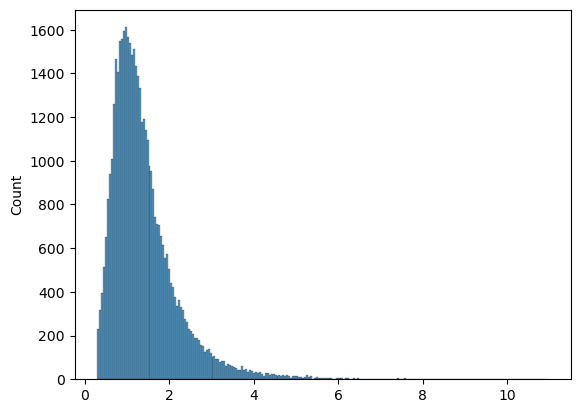

In [64]:
sns.histplot( mws.groupby("gene").apply(lambda g: g.score.mean()) )

In [65]:
mws

,Marker,pval_AltGreater,pval_AltLess,pval_two_sided,var_count,pval_AltGreater_log,pval_AltLess_log,maxscore,logpvalue,significant,gene,score,minpval
0,NC_059442.1_84727,0.023183,0.976922,0.046366,27,1.634834,0.010140,1.634834,1.333804,False,NaN,1.634834,0.023183
1,NC_059442.1_84730,0.040402,0.959767,0.080804,26,1.393595,0.017834,1.393595,1.092565,False,NaN,1.393595,0.040402
2,NC_059442.1_170604,0.001822,0.998186,0.003644,65,2.739453,0.000789,2.739453,2.438423,False,NaN,2.739453,0.001822
3,NC_059442.1_132329,0.361169,0.639526,0.722337,29,0.442290,0.194142,0.442290,0.141260,False,NaN,0.442290,0.361169
4,NC_059442.1_141907,0.129538,0.870704,0.259076,267,0.887603,0.060129,0.887603,0.586573,False,NaN,0.887603,0.129538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3440764,NW_025550964.1_235823,0.139313,0.860963,0.278626,75,0.856009,0.065016,0.856009,0.554979,False,LOC123741346,0.856009,0.139313
3440765,NW_025550964.1_236861,0.620422,0.380025,0.760050,273,0.207313,0.420188,0.420188,0.119158,False,NaN,0.420188,0.380025
3440766,NW_025550964.1_236580,0.573240,0.427447,0.854894,33,0.241664,0.369118,0.369118,0.068088,False,NaN,0.369118,0.427447
3440767,NW_025550964.1_236516,0.000010,0.999990,0.000020,26,4.999483,0.000004,4.999483,4.698453,False,NaN,4.999483,0.000010


In [66]:
genescores = mws.groupby("gene").apply(lambda g: g.score.mean())
genes_minpval = mws.groupby("gene").apply(lambda g: g.pval_two_sided.min())

In [81]:
genes_minpval

gene
1433b     0.000014
143b2     0.097173
143g1     0.045890
143g2     0.000070
2a5e      0.000939
            ...   
zte38     0.009480
zufsp     0.000192
zwilch    0.000002
zyg11     0.030646
zzef1     0.000036
Length: 45322, dtype: float64

In [82]:
mws_marker_pval = mws[["Marker", "pval_two_sided"]]
mws_marker_pval

,Marker,pval_two_sided
158771,NC_059442.1_100000138,0.662431
158772,NC_059442.1_100000703,0.834202
158773,NC_059442.1_100001620,0.843176
158774,NC_059442.1_100002064,0.029606
158777,NC_059442.1_100004543,0.068077
...,...,...
3440714,NW_025550964.1_89819,0.233627
3440718,NW_025550964.1_89847,0.659708
3440717,NW_025550964.1_94451,0.745146
3440719,NW_025550964.1_94537,0.328917


In [67]:
genes_minpval

gene
1433b     0.000014
143b2     0.097173
143g1     0.045890
143g2     0.000070
2a5e      0.000939
            ...   
zte38     0.009480
zufsp     0.000192
zwilch    0.000002
zyg11     0.030646
zzef1     0.000036
Length: 45322, dtype: float64

In [68]:
genes_minpval

gene
1433b     0.000014
143b2     0.097173
143g1     0.045890
143g2     0.000070
2a5e      0.000939
            ...   
zte38     0.009480
zufsp     0.000192
zwilch    0.000002
zyg11     0.030646
zzef1     0.000036
Length: 45322, dtype: float64

In [69]:
genes_minpval_df = pd.DataFrame(data=list(genes_minpval), index=list(genes_minpval.index), columns = ["minpval"])
genes_minpval_df

,minpval
1433b,0.000014
143b2,0.097173
143g1,0.045890
143g2,0.000070
2a5e,0.000939
...,...
zte38,0.009480
zufsp,0.000192
zwilch,0.000002
zyg11,0.030646


In [ ]:
test = pd.merge(left=genes_minpval_df, right = mws_marker_pval)

In [70]:
genes_minpval_df.to_csv("../../data/salmon_data/GFGWA_genes_minpval.csv")

In [71]:
len(genescores)

45322

In [72]:
genescores_df = pd.DataFrame(data=list(genescores), index=list(genescores.index), columns = ["log_mws_score"])
genescores_df

,log_mws_score
1433b,2.126583
143b2,0.926427
143g1,1.194061
143g2,3.678563
2a5e,0.992902
...,...
zte38,1.171855
zufsp,1.409433
zwilch,1.197783
zyg11,1.115008


In [73]:
genescores_df.to_csv("../../data/salmon_data/GFGWA_gene_results_aggregated.csv")

In [74]:
mws.to_csv("../../data/salmon_data/GFGWA_gene_results_all.csv")

In [75]:
mws["chrom"] = mws.Marker.apply(lambda x: "_".join( x.split("_")[:2] ))
mws["pos"] = mws.Marker.apply(lambda x:  x.split("_")[-1] )

In [76]:
mws = mws.sort_values(by=["chrom","pos"])

In [77]:
mws

,Marker,pval_AltGreater,pval_AltLess,pval_two_sided,var_count,pval_AltGreater_log,pval_AltLess_log,maxscore,logpvalue,significant,gene,score,minpval,chrom,pos
158771,NC_059442.1_100000138,0.331216,0.669188,0.662431,257,0.479889,0.174452,0.479889,0.178859,False,NaN,0.479889,0.331216,NC_059442.1,100000138
158772,NC_059442.1_100000703,0.583414,0.417101,0.834202,64,0.234023,0.379759,0.379759,0.078729,False,NaN,0.379759,0.417101,NC_059442.1,100000703
158773,NC_059442.1_100001620,0.578920,0.421588,0.843176,67,0.237382,0.375112,0.375112,0.074082,False,NaN,0.375112,0.421588,NC_059442.1,100001620
158774,NC_059442.1_100002064,0.014803,0.985250,0.029606,53,1.829649,0.006453,1.829649,1.528619,False,NaN,1.829649,0.014803,NC_059442.1,100002064
158777,NC_059442.1_100004543,0.966057,0.034039,0.068077,72,0.014997,1.468028,1.468028,1.166998,False,NaN,1.468028,0.034039,NC_059442.1,100004543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3440714,NW_025550964.1_89819,0.883401,0.116814,0.233627,251,0.053842,0.932506,0.932506,0.631476,False,anxa5b,0.932506,0.116814,NW_025550964.1,89819
3440718,NW_025550964.1_89847,0.329854,0.670636,0.659708,301,0.481678,0.173513,0.481678,0.180648,False,anxa5b,0.481678,0.329854,NW_025550964.1,89847
3440717,NW_025550964.1_94451,0.372573,0.627812,0.745146,204,0.428789,0.202170,0.428789,0.127759,False,anxa5b,0.428789,0.372573,NW_025550964.1,94451
3440719,NW_025550964.1_94537,0.164458,0.835852,0.328917,288,0.783944,0.077870,0.783944,0.482914,False,anxa5b,0.783944,0.164458,NW_025550964.1,94537


In [78]:
lot = []
cmax = 0
for gn,g in mws.groupby("chrom"):
    g.pos = g.pos.astype(int) - g.pos.astype(int).min() + 10000000 + cmax
    lot.append( g.sort_values(by="pos") )
    cmax = g.pos.max()
foo = pd.concat(lot)  

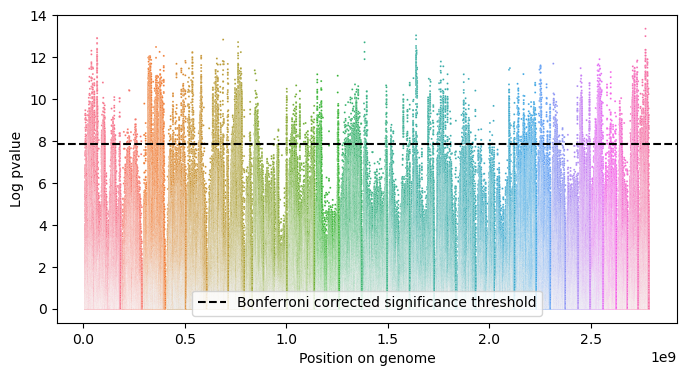

In [79]:
fig, ax = plt.subplots(figsize=(8,4))
sns.scatterplot(data = foo[foo.chrom.str.startswith("NC")],
               x = "pos",y="logpvalue", hue="chrom", 
                s=2,
               legend = False,
               ax=ax)
plt.xlabel("Position on genome")
plt.ylabel("Log pvalue")
plt.axhline(y=bonferroni_threshold, ls="--", color='k', label="Bonferroni corrected significance threshold")
plt.legend(loc="lower center")